In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp

from torch.utils.data import DataLoader, TensorDataset

In [15]:
X, y = load_diabetes(return_X_y=True)
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

X_tensor = torch.tensor(X_pca, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
n_qubits = 4
x_params = ParameterVector("x", n_qubits)
theta_params = ParameterVector("θ", 4)

qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(x_params[i], i)

# Entanglement
for i in range(n_qubits - 1):
    qc.cx(i, i + 1)
qc.cx(n_qubits - 1, 0)

for i in range(n_qubits):
    qc.ry(theta_params[i % 4], i)

# Observables for multi-output QNN
observables = [
    SparsePauliOp.from_list([("ZIII", 1)]),
    SparsePauliOp.from_list([("IZII", 1)]),
    SparsePauliOp.from_list([("IIZI", 1)]),
    SparsePauliOp.from_list([("IIIZ", 1)]),
]

estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=x_params,
    weight_params=theta_params,
    estimator=estimator,
    observables=observables,
)
qnn_layer = TorchConnector(qnn)

model = nn.Sequential(
    qnn_layer,
    nn.Linear(4, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1)
)

In [19]:
def main():
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.8)
    loss_history = []
    r2_scores = []

    num_epochs = 100

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for xb, yb in dataloader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * xb.size(0)

        scheduler.step()
        epoch_loss /= len(X_tensor)
        loss_history.append(epoch_loss)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_tensor).squeeze().numpy()
            r2 = r2_score(y, y_pred)
            r2_scores.append(r2)

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, R² Score = {r2:.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = model(X_tensor).squeeze().numpy()

    plt.figure(figsize=(8, 5))
    plt.scatter(X_pca[:, 0], y, label='True Targets', alpha=0.6)
    plt.scatter(X_pca[:, 0], y_pred, label='QNN Predictions', alpha=0.6)
    plt.xlabel("PCA Feature 1")
    plt.ylabel("Diabetes Progression")
    plt.title("Quantum Regression on Diabetes Dataset")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(loss_history, 'm-', label='MSE Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("QNN Training Loss (Batch Size 32)")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(r2_scores, 'g-', label='R² Score')
    plt.xlabel("Epoch")
    plt.ylabel("R² Score")
    plt.title("QNN R² Score Over Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

Epoch 10: Loss = 4475.8040, R² Score = 0.3413
Epoch 20: Loss = 4790.8241, R² Score = 0.0972
Epoch 30: Loss = 4045.4701, R² Score = 0.4036
Epoch 40: Loss = 3909.7916, R² Score = 0.3567
Epoch 50: Loss = 3500.2778, R² Score = 0.4660
Epoch 60: Loss = 3527.5104, R² Score = 0.4420
Epoch 70: Loss = 2989.0951, R² Score = 0.4990
Epoch 80: Loss = 3008.6709, R² Score = 0.5000
Epoch 90: Loss = 2774.9758, R² Score = 0.5510
Epoch 100: Loss = 2653.8084, R² Score = 0.5693


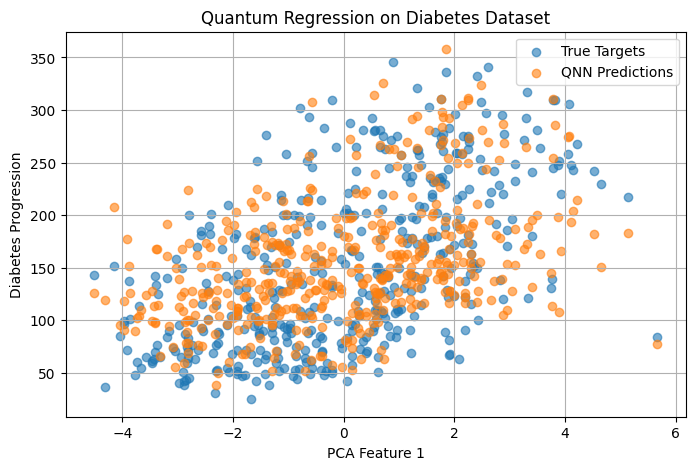

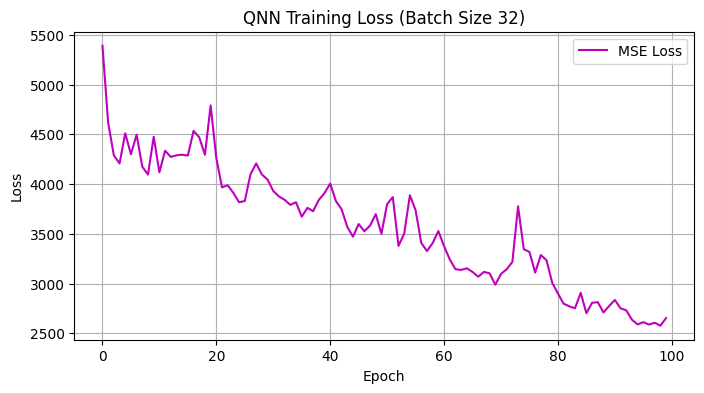

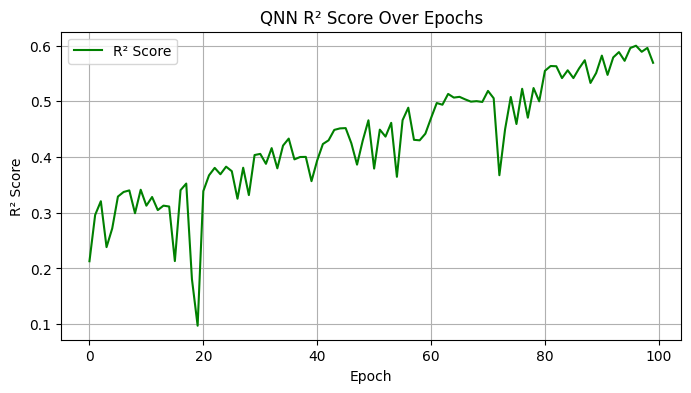

In [20]:
if __name__ == "__main__":
    main()

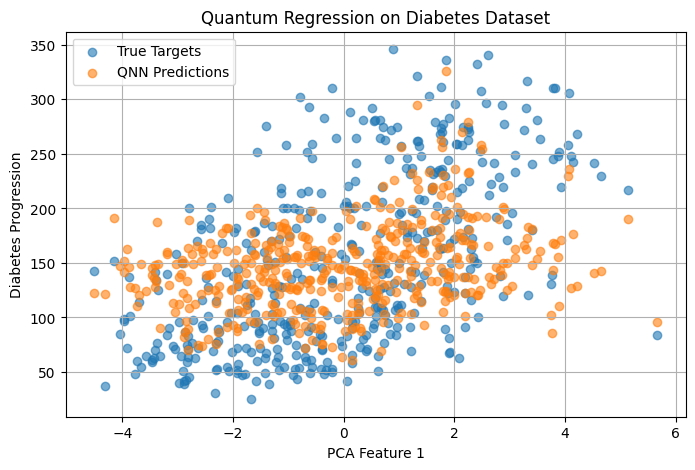

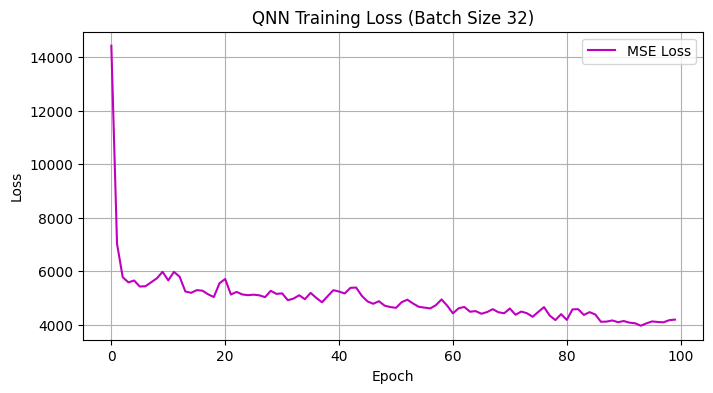

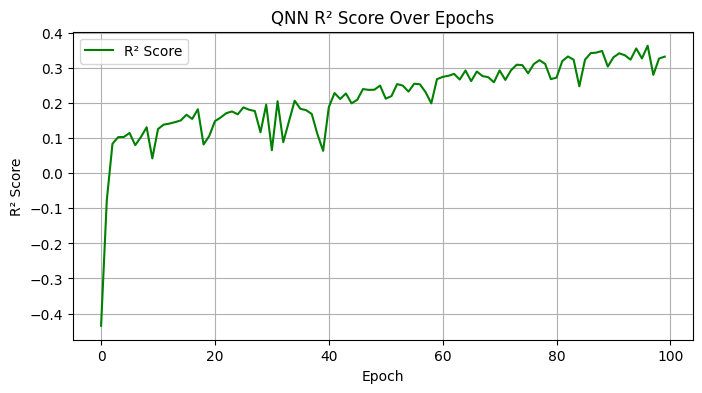

In [18]:
if __name__ == "__main__":
    main()